In [1]:
import ast

In [177]:
import matplotlib.pylab as plt
%matplotlib inline

In [219]:
import networkx as nx
from networkx.drawing.nx_agraph import write_dot, graphviz_layout

# Using ast.parse

## Effect of different modes

In [13]:
stmt_str = "4 + 5 / 3"

In [15]:
tree_exec = ast.parse(stmt_str, filename="<unknown>", mode="exec")
tree_eval = ast.parse(stmt_str, filename="<unknown>", mode="eval")
tree_single = ast.parse(stmt_str, filename="<unknown>", mode="single")

In [19]:
print(tree_exec)
print(tree_exec.body)

In [20]:
print(tree_eval)
print(tree_eval.body)

In [21]:
print(tree_single)
print(tree_single.body)

### programmatically introducing nodes requires fixing col_offset and lineno for each node

use

ast.fix_missing_locations()

ast.copy_location()

ast.increment_lineno()

### for bytecode -> ast -> source code (inverse transformations), see

astor

Meta

uncompyle6

# Node Types

In [29]:
ast.Num(4)

In [32]:
ast.Str('hello')

### List of node types:

https://greentreesnakes.readthedocs.io/en/latest/nodes.html

# Visiting Nodes

In [74]:
class FuncLister(ast.NodeVisitor):
    def visit_FunctionDef(self, node):
        print(node.name)
        self.generic_visit(node)
        
class NameLister(ast.NodeVisitor):
    def visit_Name(self, node):
        print(node.id)
        self.generic_visit(node)

In [75]:
f_str = "def f(a,b): \n\
\tdef g():\n\
\t\tprint('Hello world') \n\
\treturn a + b \
"

In [76]:
tree = ast.parse(f_str)

In [77]:
FuncLister().visit(tree)

f
g


In [78]:
NameLister().visit(tree)

print
a
b


In [50]:
??ast.NodeVisitor

In [202]:
#walk over all nodes - in no particular order
for node in ast.walk(tree):
    print(node)
    print(node.__class__)

<class '_ast.Module'>
<class '_ast.FunctionDef'>
<class '_ast.arguments'>
<class '_ast.FunctionDef'>
<class '_ast.Return'>
<class '_ast.arg'>
<class '_ast.arg'>
<class '_ast.arguments'>
<class '_ast.Expr'>
<class '_ast.BinOp'>
<class '_ast.Call'>
<class '_ast.Name'>
<class '_ast.Add'>
<class '_ast.Name'>
<class '_ast.Name'>
<class '_ast.Str'>
<class '_ast.Load'>
<class '_ast.Load'>
<class '_ast.Load'>


In [337]:
#visit child nodes of a certain node (root in this case)
for i in ast.iter_child_nodes(tree):
    print(i)

In [338]:
#manually go down the tree
print(tree.body)
print(len(tree.body))
print(tree.body[0])
print(tree.body[0].name)
print(tree.body[0].body)
print(tree.body[0].body[0].name)
print(tree.body[0].body[0].body)
print(tree.body[0].body[0].body[0].value)
print(tree.body[0].body[0].body[0].value.func.id)
print(tree.body[0].body[0].body[0].value.args)
print(tree.body[0].body[0].body[0].value.args[0].s)

print(tree.body[0].body[1].value)
print(tree.body[0].body[1].value.left.id)
print(tree.body[0].body[1].value.right.id)
print(tree.body[0].body[1].value.op)

1
f
[<_ast.FunctionDef object at 0x7fd8b5453588>, <_ast.Return object at 0x7fd8b54536d8>]
g
print
Hello world
a
b


In [339]:
#all fields of a node
for i in ast.iter_fields(tree.body[0]):
    print(i)

('name', 'f')
('args', <_ast.arguments object at 0x7fd8b54534e0>)
('body', [<_ast.FunctionDef object at 0x7fd8b5453588>, <_ast.Return object at 0x7fd8b54536d8>])
('decorator_list', [])
('returns', None)


# Breadth-first search

In [341]:
def bfs(root):
    '''tree -> don't need to store visited booleans
    '''
    nodes_seen = [root]
    
    current_visit_index = 0
    N_nodes = 1
    
    while current_visit_index != N_nodes:
        current_node = nodes_seen[current_visit_index]
        current_visit_index += 1
        
        print(current_node)
        
        for child in ast.iter_child_nodes(current_node):
            nodes_seen.append(child)
            N_nodes += 1
            
#these labels are used to make the tree more readable
text_labels = {
    ast.Module: lambda x:'ROOT',
    ast.FunctionDef: lambda x: x.name,
    ast.arguments: lambda x: 'ARGS',
    ast.Return: lambda x: 'RETURN',
    ast.arg: lambda x: x.arg,
    ast.BinOp: lambda x: x.op,
    ast.Name: lambda x: x.id,
    ast.Call: lambda x: x.func,
    ast.Str: lambda x: x.s,
    ast.Load: lambda x: 'LOAD',
    ast.Store: lambda x: 'STORE',
    ast.Del: lambda x: 'DEL',
    ast.Expr: lambda x: x.value,
    ast.Add: lambda x: 'ADD',
    ast.Sub: lambda x: 'SUBTRACT',
    ast.Mult: lambda x: 'MULT'
}


def bfs_draw(root):
    '''tree -> don't need to store visited booleans
    '''
    nodes_seen = [root]
    
    current_visit_index = 0
    N_nodes = 1
    
    tree_nx = nx.DiGraph()
    tree_nx.add_node(nodes_seen[current_visit_index]) #add root
    
    while current_visit_index != N_nodes:
        current_node = nodes_seen[current_visit_index]
        current_visit_index += 1
        
        print(current_node)
        
        for child in ast.iter_child_nodes(current_node):
            nodes_seen.append(child)
            
            #node-specific processing
            tree_nx.add_node(child)
            tree_nx.add_edge(current_node, child)
            
            N_nodes += 1
    
    #rename nodes for more readable names
    mapping = {node: text_labels.get(node.__class__)(node) for node in tree_nx.nodes}
    tree_nx = nx.relabel_nodes(tree_nx, mapping)
            
    return tree_nx

In [342]:
bfs(tree)

In [343]:
tree_nx = bfs_draw(tree)

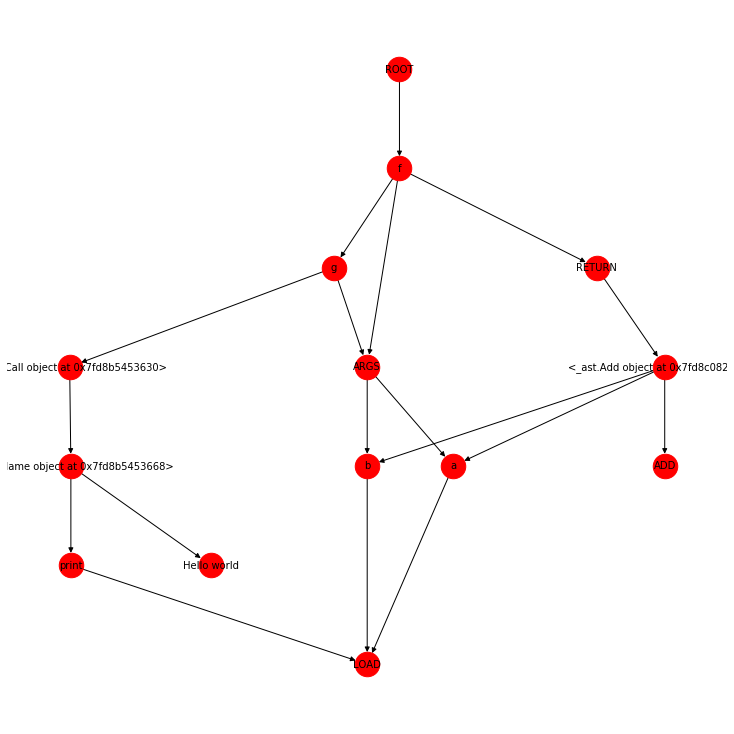

In [344]:
# same layout using matplotlib with no labels
fig = plt.figure(figsize=(10,10))
pos = graphviz_layout(tree_nx, prog='dot')
nx.draw(tree_nx, pos, with_labels=True, arrows=True, node_size=600, font_size=10)